# Spaceship Titanic

This notebook analyses Spaceship Titanic dataset downloaded from [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data).

In Kaggle's competition, the task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly. To assist with these predictions, a set of personal records, recovered from the ship's damaged computer system, is provided.

## Goal

The goal of this project is to develop a model that identifies passengers who were transported to an alternate dimension.

## Objectives

To achieve this goal, the following objectives have been established:

1. Download, load and clean the dataset.
2. Conduct exploratory data analysis and visualize data to identify underlying patterns.
3. Perform statistical inference to validate findings.
4. Apply machine learning models to predict which passengers were lost.
5. Summarize the results and provide recommendations.

---
## Libraries

In [283]:
import os
import time
import warnings
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from fancyimpute import KNN
from IPython.display import display
from lightgbm import LGBMClassifier
from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)
from xgboost import XGBClassifier

%run formulas_titanic.ipynb

In [284]:
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [285]:
from IPython.core.display import HTML

HTML(
    """
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""
)

In [286]:
plt.rcParams.update(
    {
        "font.family": "Trebuchet MS",
        "axes.titlesize": 10,
        "axes.titlepad": 13,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 9,
        "legend.title_fontsize": 9,
    }
)

custom_palette = [
    "#001219",
    "#005F73",
    "#0A9396",
    "#94D2BD",
    "#E9D8A6",
    "#EE9B00",
    "#CA6702",
    "#BB3E03",
    "#AE2012",
    "#9B2226",
]

custom_cmap = ListedColormap(custom_palette)

---
## Dataset

In [288]:
df = pd.read_csv(r"C:\Users\nacev\OneDrive\turing\datasets\train.csv")
test = pd.read_csv(r"C:\Users\nacev\OneDrive\turing\datasets\test.csv")

In [289]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True


In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


The dataset comprises information about 8693 passengers and includes 14 features:

- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the column we will be trying to predict.

In [292]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

There are some missing values which will be dealt with later.

In [294]:
for column in df.columns:
    num_unique = df[column].nunique()
    print(f"Number of unique values in {column}: {num_unique}")

Number of unique values in PassengerId: 8693
Number of unique values in HomePlanet: 3
Number of unique values in CryoSleep: 2
Number of unique values in Cabin: 6560
Number of unique values in Destination: 3
Number of unique values in Age: 80
Number of unique values in VIP: 2
Number of unique values in RoomService: 1273
Number of unique values in FoodCourt: 1507
Number of unique values in ShoppingMall: 1115
Number of unique values in Spa: 1327
Number of unique values in VRDeck: 1306
Number of unique values in Name: 8473
Number of unique values in Transported: 2


- *PassengerId*, *Cabin* & *Name* have high-cardinality, although they can be split into new features.
- Expenditure features can also be combined into one total figure.

In [296]:
duplicates = df[df.duplicated()]
num_duplicates = duplicates.shape[0]

print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


The dataset does not contain duplicate entries.

In [298]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000,8512.000,8510.000,8485.000,8510.000,8505.000
mean,28.828,224.688,458.077,173.729,311.139,304.855
std,14.489,666.718,1611.489,604.696,1136.706,1145.717
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,19.000,0.000,0.000,0.000,0.000,0.000
50%,27.000,0.000,0.000,0.000,0.000,0.000
75%,38.000,47.000,76.000,27.000,59.000,46.000
max,79.000,14327.000,29813.000,23492.000,22408.000,24133.000


Looking at the numerical features, the passengers are from 0 to 79 years old, and the average age is around 28.8 years. 75% of passengers are aged 38 or younger, showing that the passenger population was quite young.

Regarding spending figures, it can already be seen that more than half of the passengers spent no money, while there were a few that spent quite a lot. Each spending category shows a high standard deviation, indicating substantial variability in spending among passengers.

&nbsp;

---

## Exploratory Data Analysis

In this section the dataset is examined to gain insights and understand its characteristics.

### Overview

In [303]:
expense_features = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

binary_features = [
    "CryoSleep",
    "VIP",
]

categorical_features = ["HomePlanet", "Destination"]

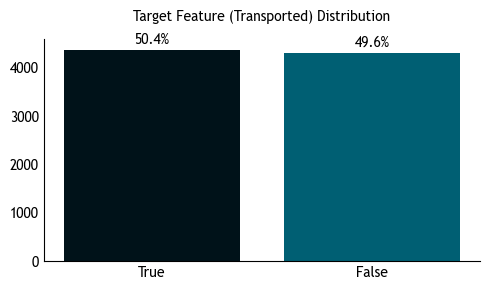

In [304]:
fig, ax = plt.subplots(figsize=(5, 3))

create_countplot(
    df=df,
    ax=ax,
    col="Transported",
    colors=custom_palette,
    percent=1,
)

ax.set(title="Target Feature (Transported) Distribution")

plt.tight_layout()
plt.show()

The bar chart of the dependent variable **Transported** shows the distribution of passengers who were either transported to an alternate dimension or not. The split is almost equal, and with transported passengers accounting for 50.4% population, we have a balanced distribution.

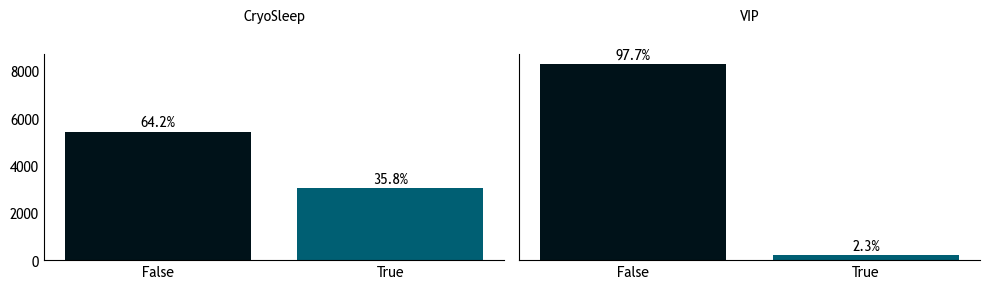

In [306]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for i, col in enumerate(binary_features[:2]):
    create_countplot(
        df=df,
        ax=axes[i],
        col=col,
        colors=custom_palette,
        percent=1,
    )
    axes[i].set(title=f"{col}\n")

plt.tight_layout()
plt.show()

The first bar chart illustrates the distribution of the CryoSleep feature, which indicates whether passengers were in suspended animation. More than a third (35.3%) passengers were in CryoSleep. Conversely, the majority of passengers (64.7%) were not in CryoSleep. 

The second bar chart presents the distribution of the VIP feature. The chart reveals that a very small fraction of passengers (2.3%) were VIPs. This indicates that VIP status was quite rare among the passengers.

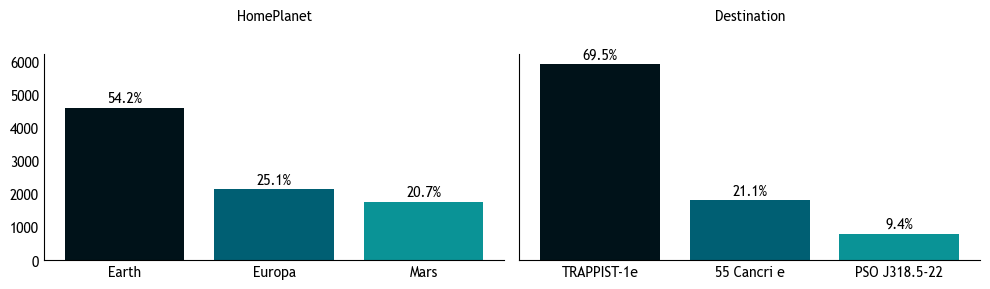

In [308]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for i, col in enumerate(categorical_features[:2]):
    create_countplot(
        df=df,
        ax=axes[i],
        col=col,
        colors=custom_palette,
        percent=1,
    )
    axes[i].set(title=f"{col}\n")

plt.tight_layout()
plt.show()

A little over half of the passengers (54.2%) come from Earth, making it the most common home planet in the dataset. In contrast, around 25% passengers originated from Europa. The least common origin is Mars, with only 20.7% of passengers hailing from there.

A substantial majority (69.5%) of passengers are headed to TRAPPIST-1e, indicating that it is the most popular destination. In comparison, 21.1% of passengers are destined for 55 Cancri e, while the least favored destination is PSO J318.5-22, with only 9.4% of passengers traveling there. 

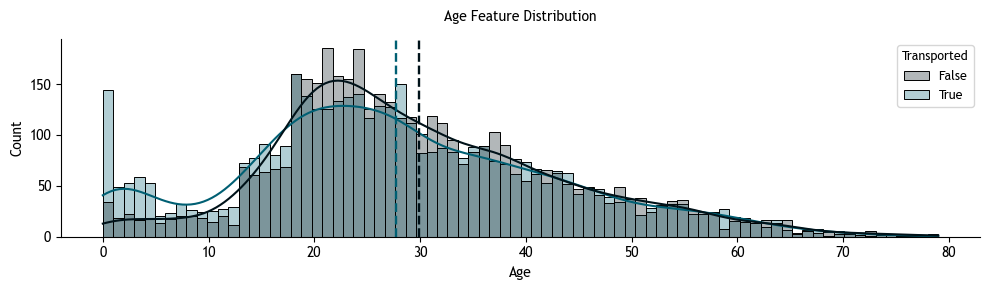

In [310]:
mean_age_transported = df[df["Transported"] == 1]["Age"].mean()
mean_age_not_transported = df[df["Transported"] == 0]["Age"].mean()

fig, ax = plt.subplots(figsize=(10, 3))

sns.histplot(
    x=df["Age"],
    hue="Transported",
    data=df,
    kde=True,
    bins=80,
    alpha=0.3,
    linewidth=0.7,
    palette=custom_palette[0:2],
    ax=ax,
)

ax.axvline(mean_age_transported, color=custom_palette[1], linestyle="--", linewidth=1.7)
ax.axvline(
    mean_age_not_transported, color=custom_palette[0], linestyle="--", linewidth=1.7
)

sns.despine()
ax.set_title("Age Feature Distribution")

plt.tight_layout()
plt.show()

Analyzing the age of passengers who were transported, it appears that those aged 0-18 were transported significantly more frequently. In contrast, adults, particularly those between 19 and 38 years old, were less likely to be transported. The difference among older age groups is minimal.

Additionally, the average age of transported passengers is a few years lower, around 28.

As a result, a new age group feature will be created to further explore the influence of age on the target variable.

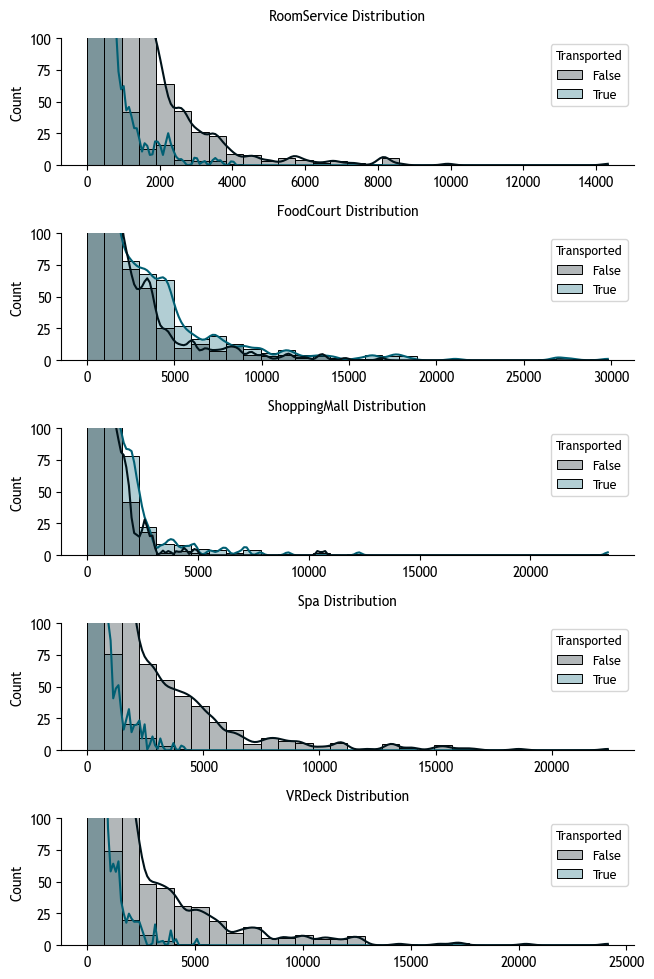

In [312]:
fig, axes = plt.subplots(5, 1, figsize=(7, 11), sharey=True)

for i, col in enumerate(expense_features):
    sns.histplot(
        x=col,
        hue="Transported",
        data=df,
        bins=30,
        kde=True,
        alpha=0.3,
        ax=axes[i],
        palette=custom_palette[0:2],
        linewidth=0.7,
    )

    axes[i].set_title(f"{col} Distribution")
    axes[i].set_ylim(0, 100)
    axes[i].set_xlabel("")

sns.despine()

plt.tight_layout(rect=[0, 0, 0.95, 0.9])
plt.show()

Plotting the expenditure features reveals that most passengers spent little to no money, while a few individuals spent a significant amount.

Interestingly, the expenditure features influenced the target variable differently. Spending on service features (room service, spa, and VRdeck) decreased the likelihood of being transported. In contrast, passengers who spent more on shopping features (food court and shopping mall) were slightly more likely to be transported than those who did not.

Taking this into account, new features will be created later: total, shopping, and service expenditure, as well as a binary 'No Spending' feature, which will categorize passengers into two groups - those who spent something and those who did not.

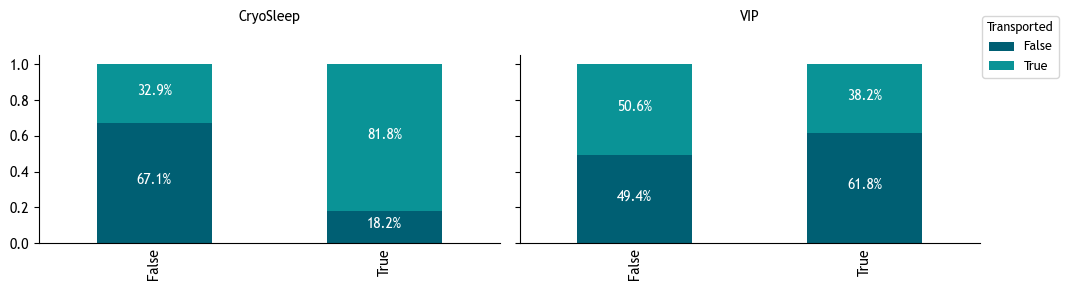

In [314]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

for i, col in enumerate(binary_features[:2]):
    create_stacked_barchart(
        df=df,
        ax=axes[i],
        col_x=col,
        col_hue="Transported",
        colors=custom_palette[1:],
        percent=True,
    )
    axes[i].set(title=f"{col}\n")

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles, labels, loc="upper right", bbox_to_anchor=(1.07, 0.95), title="Transported"
)

plt.tight_layout()
plt.show()

Examining the CryoSleep and VIP features in relation to the target variable reveals a significant difference for those placed in suspended animation. Passengers who chose CryoSleep were transported about 2.5 times more often (81.8%) than those who did not (32.9%).

In contrast, the VIP feature appears less important, with only a 12% difference in transportation rates (50.6% for non-VIPs compared to 38.2% for VIPs). Although being a VIP seems to slightly decrease the likelihood of being transported, it's important to note that only 2.3% of passengers were VIPs.

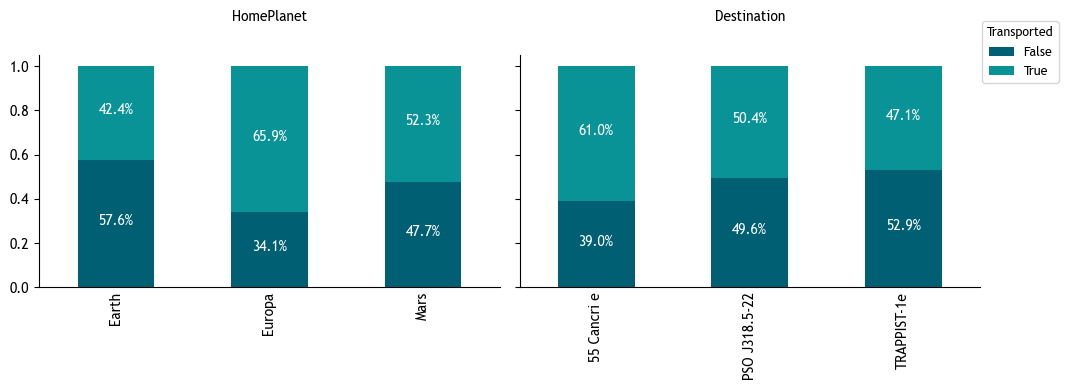

In [316]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, col in enumerate(categorical_features[:2]):
    create_stacked_barchart(
        df=df,
        ax=axes[i],
        col_x=col,
        col_hue="Transported",
        colors=custom_palette[1:],
        percent=True,
    )
    axes[i].set(title=f"{col}\n")

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles, labels, loc="upper right", bbox_to_anchor=(1.07, 0.95), title="Transported"
)

plt.tight_layout()
plt.show()

There were some differences in the likelihood of being transported among passengers from different home planets and those heading to different destinations.

Passengers from Europa had the highest transportation rate (65.9%). About half of those from Mars (52.23%) were transported, while Earth inhabitants were the least likely to be transported (42.4%).

There was less variation across destinations. Passengers traveling to 55 Cancri e were transported most often (61%), while around half of those headed to the other two planets were transported.

Next, missing values are dealt with and new features are created.

### Feature Engineering

As mentioned earlier, some features can be transformed into new ones:
- The Cabin feature will be split into CabinDeck, CabinNumber, and Side.
- PassengerID will be used to create GroupNumber, GroupSize (number of passengers in a group), and TravellingSolo (indicating if the passenger is traveling alone).
- Expense columns will be aggregated to form TotalExpenditure, ServiceExpenditure (RoomService, Spa, VRDeck), ShoppingExpenditure (FoodCourt, ShoppingMall), and NoSpending (True if total spending is zero, False otherwise).
- The Name feature will be split into FirstName and Surname.
- The Age feature will be used to create an AgeGroup feature.

These transformations will be applied before the statistical inference and modeling phases to help fill missing values and gain further insights into the data.

In [321]:
cabin_split = SplitCabin()
df = cabin_split.fit_transform(df)

group_features = GroupFeatures()
df = group_features.fit_transform(df)

expenditure_features = ExpenditureFeatures()
df = expenditure_features.fit_transform(df)

extract_surname = ExtractSurname()
df = extract_surname.fit_transform(df)

age_bins = [0, 13, 19, 25, 35, 45, 55, 65, 100]
age_labels = ["0-12", "13-18", "19-24", "25-34", "35-44", "45-54", "55-64", "65+"]

age_binning = AgeBinning(age_bins, age_labels)
df = age_binning.fit_transform(df)

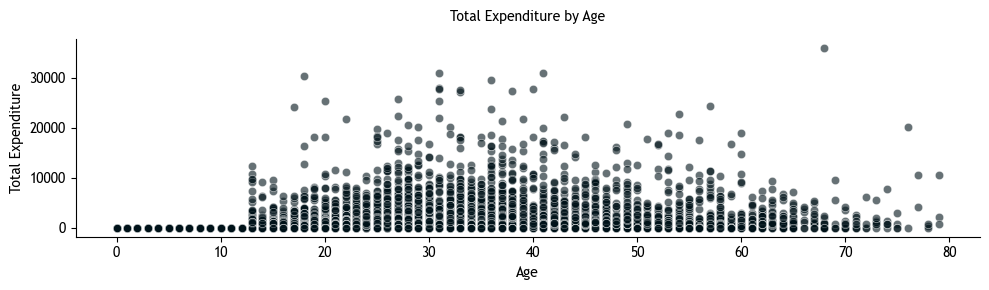

In [322]:
plt.figure(figsize=(10, 3))

sns.scatterplot(
    x="Age", y="TotalExpenditure", data=df, alpha=0.6, color=custom_palette[0]
)

plt.title("Total Expenditure by Age")
plt.xlabel("Age")
plt.ylabel("Total Expenditure")

sns.despine()

plt.tight_layout()
plt.show()

The scatterplot above helps distinguish passengers into distinct age groups. It appears that children up to 12 years old did not spend any money. Beyond that, it is difficult to observe any clear differences between the age groups.

### Visualizing New Features

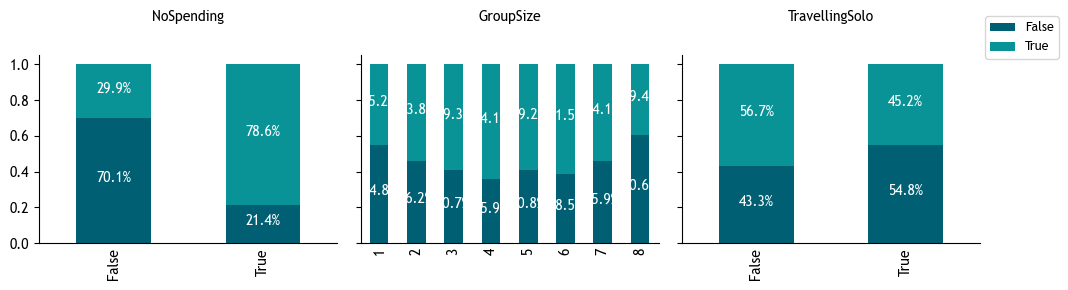

In [325]:
columns_to_plot = ["NoSpending", "GroupSize", "TravellingSolo"]

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(10, 3), sharey=True)

for i, col in enumerate(columns_to_plot):
    create_stacked_barchart(
        df=df,
        ax=axes[i],
        col_x=col,
        col_hue="Transported",
        colors=custom_palette[1:],
        percent=True,
    )
    axes[i].set(title=f"{col}\n")

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.07, 0.95))

plt.tight_layout()
plt.show()

The newly created features offer valuable insights. Notably, having no expenses significantly increased the likelihood of being transported - almost 79% of passengers with no spending were transported, compared to only 30% of those who spent any money.

Group size had a smaller effect than spending. However, solo travelers and those in groups of 8 were less likely to be transported. A clearer distinction emerges when comparing solo travelers to those in groups - being part of a group increased the likelihood of being transported by around 13%.

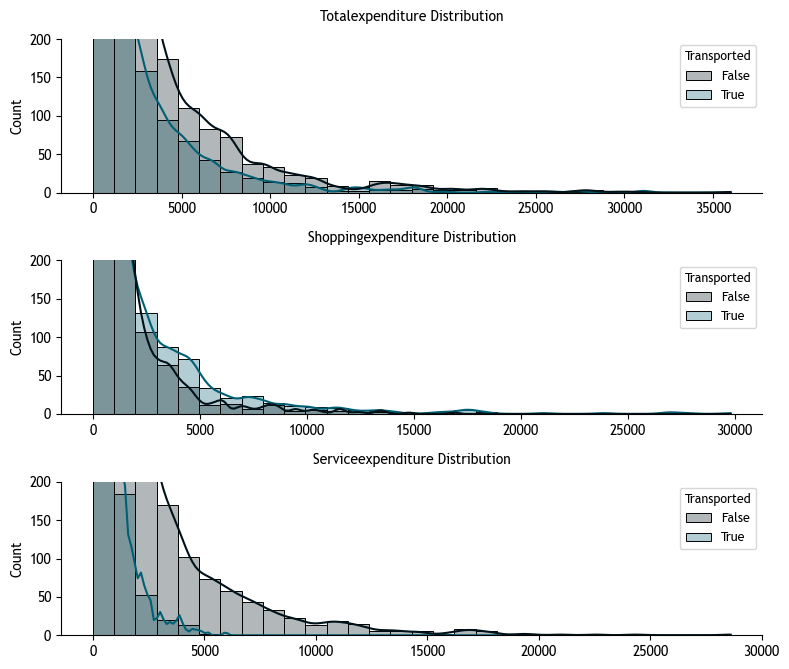

In [327]:
expenditure_columns = ["TotalExpenditure", "ShoppingExpenditure", "ServiceExpenditure"]

fig, axes = plt.subplots(len(expenditure_columns), 1, figsize=(8, 7), sharey=True)

for i, col in enumerate(expenditure_columns):
    sns.histplot(
        x=df[col],
        hue="Transported",
        data=df,
        bins=30,
        kde=True,
        alpha=0.3,
        ax=axes[i],
        palette=custom_palette[0:2],
        linewidth=0.7,
    )

    axes[i].set_title(f"{col.title()} Distribution")
    axes[i].set_ylim(0, 200)
    axes[i].set_xlabel("")

sns.despine()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Examining total expenditure confirms the trend observed from individual features - spending more reduces the likelihood of being transported.

Interestingly, shopping and service expenses correlate differently with the target variable. While higher spending on services decreases the likelihood of being transported, spending on shopping slightly increases it.

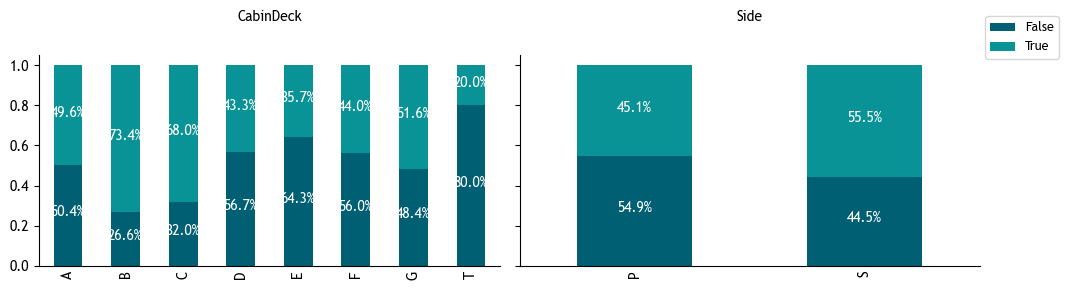

In [329]:
columns_to_plot = ["CabinDeck", "Side"]

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(10, 3), sharey=True)

for i, col in enumerate(columns_to_plot):
    create_stacked_barchart(
        df=df,
        ax=axes[i],
        col_x=col,
        col_hue="Transported",
        colors=custom_palette[1:],
        percent=True,
    )
    axes[i].set(title=f"{col}\n")

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.07, 0.95))

plt.tight_layout()
plt.show()

While the side of the ship had some influence on the likelihood of being transported (around 45% on the P side versus 56% on the S side), the cabin deck showed greater variability. Passengers on decks D, E, F, and T were more likely to remain on the ship.

### Missing Values

Next, we will address the missing values.

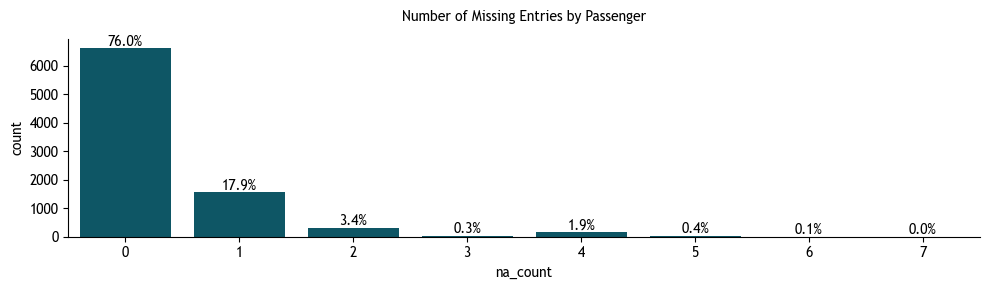

In [333]:
df["na_count"] = df.isna().sum(axis=1)

plt.figure(figsize=(10, 3))
ax = sns.countplot(data=df, x="na_count", color=custom_palette[1])

total_count = len(df)
na_counts = df["na_count"].value_counts().sort_index()

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.annotate(
        f"{percentage:.1f}%",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

sns.despine()
plt.title("Number of Missing Entries by Passenger")
plt.tight_layout()

df.drop("na_count", axis=1, inplace=True)

plt.show()

As shown in the graph above, despite features having only around 2% missing values and the majority of passengers having just 1-2 missing entries, approximately 24% of the rows are not fully completed.

Therefore, we will examine relationships between features to help fill in the missing values.

In [335]:
expenditures_summary = df.groupby("CryoSleep")["TotalExpenditure"].sum().reset_index()

expenditures_summary.columns = ["CryoSleep", "TotalExpenditure"]
expenditures_summary

,CryoSleep,TotalExpenditure
0,False,12228502.000
1,True,0.000


It is logical to assume that passengers who were in suspended animation for the trip did not spend any money. Indeed, the total amount spent by these passengers was zero. Therefore, missing expenditure values for these passengers will be filled with zeroes.

Additionally, as observed earlier, children did not spend any money. The dataset will be updated to reflect this by setting the expenditure values for these passengers to zero.

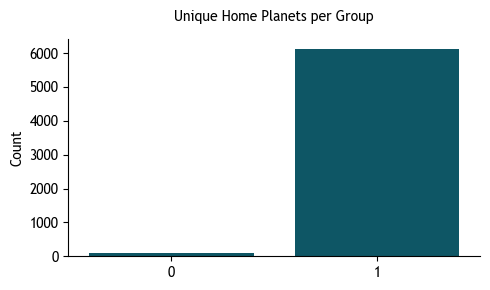

In [337]:
unique_values = (
    df.groupby("GroupNumber").agg({"HomePlanet": pd.Series.nunique}).reset_index()
)

fig, ax = plt.subplots(figsize=(5, 3))

sns.countplot(data=unique_values, x="HomePlanet", color=custom_palette[1], ax=ax)

ax.set_title("Unique Home Planets per Group")
ax.set_xlabel("")
ax.set_ylabel("Count")

sns.despine()

plt.tight_layout()
plt.show()

Next, we need to check that people in the same group are traveling from the same home planet. However, some missing values may still remain due to individuals traveling alone.

In [339]:
pivot_table = df.pivot_table(
    index="CabinDeck", columns="HomePlanet", aggfunc="size", fill_value=0
)
pivot_table

HomePlanet,Earth,Europa,Mars
CabinDeck,,,
A,0,252,0
B,0,766,0
C,0,734,0
D,0,186,282
E,395,128,330
F,1614,0,1110
G,2498,0,0
T,0,4,0


The relationship between home planet and cabin deck reveals some patterns:

- Cabins A, B, C, and T were exclusively occupied by passengers from Europa.
- Cabin G was exclusively occupied by passengers from Earth.
  
Other cabins had a mix of passengers from different home planets.

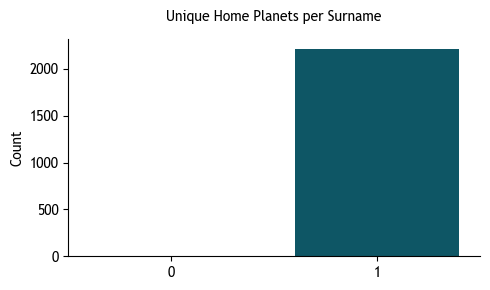

In [341]:
unique_values = (
    df.groupby("Surname").agg({"HomePlanet": pd.Series.nunique}).reset_index()
)

fig, ax = plt.subplots(figsize=(5, 3))

sns.countplot(data=unique_values, x="HomePlanet", color=custom_palette[1], ax=ax)

ax.set_title("Unique Home Planets per Surname")
ax.set_xlabel("")
ax.set_ylabel("Count")

sns.despine()
plt.tight_layout()
plt.show()

It is also evident that passengers who share the same surname are traveling from the same home planet.

Additionally, it can be assumed that VIPs are likely to be adults.

In [344]:
min_age_vip_true = df[df["VIP"] == True]["Age"].min()

print(f"Minimum Age where VIP is True: {min_age_vip_true}")

Minimum Age where VIP is True: 18.0


To further impute VIP values, we can examine the relationship between home planet and VIP status.

In [346]:
pivot_table = df.pivot_table(
    index="VIP", columns="HomePlanet", aggfunc="size", fill_value=0
)
pivot_table

HomePlanet,Earth,Europa,Mars
VIP,,,
False,4487,1958,1653
True,0,131,63


It can be observed that none of the passengers from Earth were VIPs.

Additionally, we can assume that passengers from the same group have matching cabin decks, numbers, and sides.

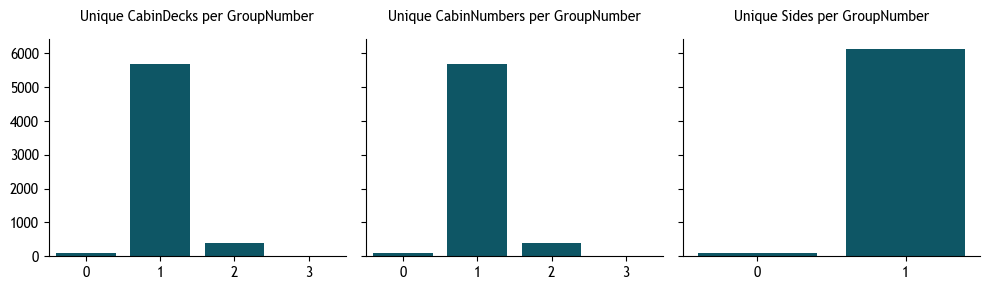

In [349]:
unique_values = (
    df.groupby("GroupNumber")
    .agg(
        {
            "CabinDeck": pd.Series.nunique,
            "CabinNumber": pd.Series.nunique,
            "Side": pd.Series.nunique,
        }
    )
    .reset_index()
)

titles = [
    "Unique CabinDecks per GroupNumber",
    "Unique CabinNumbers per GroupNumber",
    "Unique Sides per GroupNumber",
]

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for ax, x, title in zip(axes, ["CabinDeck", "CabinNumber", "Side"], titles):
    sns.countplot(data=unique_values, x=x, ax=ax, color=custom_palette[1])
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")

sns.despine()
plt.tight_layout()
plt.show()

While we cannot assign the same cabin deck or number to each group, as there were 1-3 different options per group, all members of a group were on the same side of the ship.

Finally, based on the insights gathered, we can establish and apply rules to fill in some of the missing values.

Since new features were created from columns with missing values to identify trends and establish rules, these features will be dropped before imputing the rest of missing data and recalculated afterward.

In [352]:
missing_data_rules = MissingDataRules()
df = missing_data_rules.fit_transform(df)

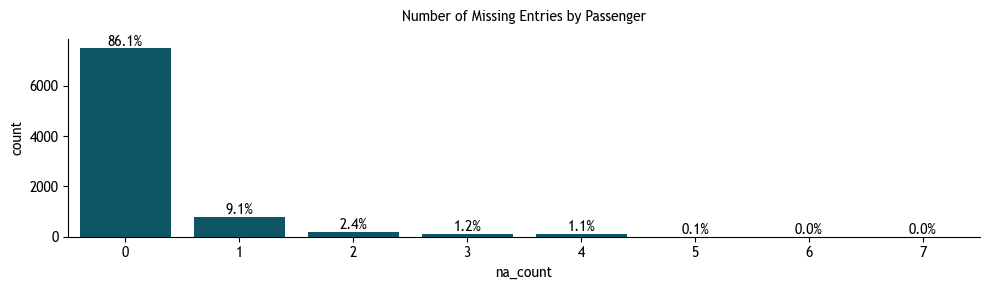

In [353]:
df["na_count"] = df.isna().sum(axis=1)

plt.figure(figsize=(10, 3))
ax = sns.countplot(data=df, x="na_count", color=custom_palette[1])

total_count = len(df)
na_counts = df["na_count"].value_counts().sort_index()

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.annotate(
        f"{percentage:.1f}%",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

sns.despine()
plt.title("Number of Missing Entries by Passenger")
plt.tight_layout()

df.drop("na_count", axis=1, inplace=True)

plt.show()

We were able to reduce the percentage of rows with missing values from 24% to 14%.

Finally, the remaining missing values that we could not fill manually will be addressed using imputers. Unnecessary columns will be dropped, and the column order will be adjusted.

In [356]:
numerical_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

exp_columns_to_drop = [
    "TotalExpenditure",
    "ShoppingExpenditure",
    "ServiceExpenditure",
    "NoSpending",
    "AgeGroup",
]

numerical_input = NumericalDataInput(
    columns_to_drop=exp_columns_to_drop, numerical_features=numerical_features, k=5
)

train_final = numerical_input.fit_transform(df)

In [357]:
cat_cols = [
    "Cabin",
    "HomePlanet",
    "Destination",
    "CryoSleep",
    "VIP",
    "CabinDeck",
    "Side",
    "CabinNumber",
]

categorical_imputer = CategoricalImputer(cat_cols)

train_final = categorical_imputer.fit_transform(train_final)

In [358]:
transformers = [cabin_split, group_features, expenditure_features, age_binning]

for transformer in transformers:
    train_final = transformer.fit_transform(train_final)

In [359]:
columns_to_drop = ["Cabin", "GroupNumber"]
new_column_order = [
    "PassengerId",
    "HomePlanet",
    "Destination",
    "Age",
    "AgeGroup",
    "CryoSleep",
    "VIP",
    "GroupSize",
    "TravellingSolo",
    "CabinDeck",
    "CabinNumber",
    "Side",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalExpenditure",
    "ServiceExpenditure",
    "ShoppingExpenditure",
    "NoSpending",
    "Transported",
]

clean_order = CleanFinalVersion(columns_to_drop, new_column_order)

train_final = clean_order.fit_transform(train_final)

In [360]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          8693 non-null   object  
 1   HomePlanet           8693 non-null   object  
 2   Destination          8693 non-null   object  
 3   Age                  8693 non-null   float64 
 4   AgeGroup             8693 non-null   category
 5   CryoSleep            8693 non-null   object  
 6   VIP                  8693 non-null   object  
 7   GroupSize            8693 non-null   int64   
 8   TravellingSolo       8693 non-null   bool    
 9   CabinDeck            8693 non-null   object  
 10  CabinNumber          8693 non-null   object  
 11  Side                 8693 non-null   object  
 12  RoomService          8693 non-null   float64 
 13  FoodCourt            8693 non-null   float64 
 14  ShoppingMall         8693 non-null   float64 
 15  Spa                  

It can be seen that the dataset no longer has any missing values, and the newly calculated features have been included.

### Correlations

To explore the relationships between variables, a correlation matrix was plotted.

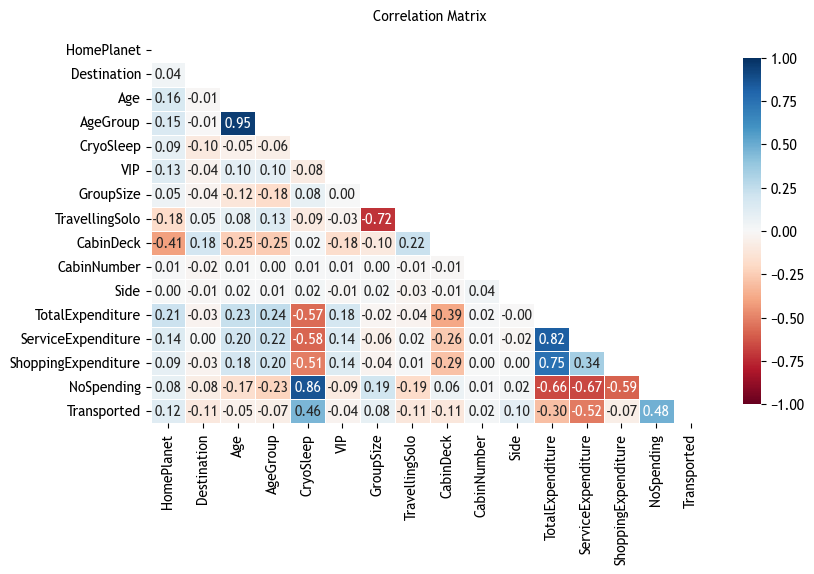

In [407]:
label_encoder = LabelEncoder()
df_encoded = train_final.drop(
    columns=[
        "PassengerId",
        "RoomService",
        "FoodCourt",
        "ShoppingMall",
        "Spa",
        "VRDeck",
    ]
)
df_encoded = df_encoded.apply(label_encoder.fit_transform)

corr_matrix = df_encoded.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(9, 5))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.9},
)

plt.title("Correlation Matrix")
plt.show()

The correlation matrix reveals that CryoSleep has a moderate positive correlation with being transported (0.460), indicating that passengers who opted for CryoSleep were more likely to be transported. 

Conversely, both TotalExpenditure and ServiceExpenditure have moderate negative correlations (-0.302 and -0.520, respectively), suggesting that higher spending is associated with a lower likelihood of being transported. NoSpending also shows a notable positive correlation (0.482), meaning passengers who did not spend any money were more likely to be transported. 

HomePlanet and Destination have weak correlations (0.120 and -0.108), indicating a minor influence on transportation likelihood. Age and AgeGroup, along with GroupSize and TravellingSolo, show very weak correlations, suggesting minimal impact. CabinDeck and Side also have small effects, while VIP and CabinNumber exhibit negligible correlations with transportation likelihood. 

Overall, CryoSleep and expenditure-related features are most significantly related to whether passengers were transported.

&nbsp;

---

## Statistical Inference

Further, statistical inference will be performed.

**Target Population:** 8,693 passengers of the Titanic Starship.

**Significance Level**: The significance level (α) is chosen to be 0.05.

### First Hypothesis

**Null Hypothesis (H0):** There is no difference in the distribution of age between individuals who were transported and those who were not.

**Alternative Hypothesis (H1):** There is a difference in the distribution of age between individuals who were transported and those who were not.

In [95]:
from scipy.stats import shapiro

age_transported = train_final.loc[train_final["Transported"] == True, "Age"]
age_not_transported = train_final.loc[train_final["Transported"] == False, "Age"]

stat_transported, p_value_transported = shapiro(age_transported)
stat_not_transported, p_value_not_transported = shapiro(age_not_transported)

print("Shapiro-Wilk Test for Age (Transported = True):")
print(f"Test Statistic: {stat_transported:.3f}, P-value: {p_value_transported:.3f}")

print("\nShapiro-Wilk Test for Age (Transported = False):")
print(
    f"Test Statistic: {stat_not_transported:.3f}, P-value: {p_value_not_transported:.3f}"
)

Shapiro-Wilk Test for Age (Transported = True):
Test Statistic: 0.984, P-value: 0.000

Shapiro-Wilk Test for Age (Transported = False):
Test Statistic: 0.973, P-value: 0.000


The Shapiro-Wilk tests for normality returned p-values of 0.000, suggesting significant deviations from normal distribution for both samples. Consequently, a non-parametric test will be employed to test the null hypothesis.

In [97]:
statistic, p_value = stats.mannwhitneyu(age_transported, age_not_transported)

mean_transport, lower_ci_transport, upper_ci_transport = calculate_confidence_interval(
    age_transported
)

mean_not_transport, lower_ci_not_transport, upper_ci_not_transport = (
    calculate_confidence_interval(age_not_transported)
)

print(
    f"Mean Age for Transported: {mean_transport:.2f}, Confidence Interval: ({lower_ci_transport:.2f}, {upper_ci_transport:.2f})"
)
print(
    f"Mean Age for Not Transported: {mean_not_transport:.2f}, Confidence Interval: ({lower_ci_not_transport:.2f}, {upper_ci_not_transport:.2f})"
)

statistic, p_value = stats.mannwhitneyu(age_transported, age_not_transported)

print(f"Mann-Whitney U Test: p-value = {p_value:.3f}")

Mean Age for Transported: 27.98, Confidence Interval: (27.53, 28.43)
Mean Age for Not Transported: 29.99, Confidence Interval: (29.58, 30.40)
Mann-Whitney U Test: p-value = 0.000


The mean age of transported passengers is 27.98 years (CI: 27.53–28.43), while for those not transported, it is 29.99 years (CI: 29.58–30.40). The Mann-Whitney U test yields a p-value of 0.000, indicating a statistically significant difference in age between the two groups.

### Second Hypothesis

**Null Hypothesis (H0):** There is no significant correlation between categorical independent variables and the dependent variable.

**Alternative Hypothesis (H1):** There is a significant correlation between categorical independent variables and the dependent variable.

In [103]:
all_categorical = [
    "HomePlanet",
    "Destination",
    "AgeGroup",
    "CryoSleep",
    "VIP",
    "GroupSize",
    "TravellingSolo",
    "CabinDeck",
    "Side",
    "NoSpending",
]

In [104]:
alpha = 0.05
num_comparisons = len(all_categorical) - 1
bonferroni_alpha = alpha / num_comparisons
bonferroni_alpha

0.005555555555555556

The significance level is set to be 0.05. Since multiple comparisons are going to be made, the significance level needs to be adjusted to account for the increased chance of Type I errors due to multiple tests.

Therefore, each test would need to have a p-value less than 0.0056 to be considered statistically significant.

In [106]:
for col in all_categorical:
    if col != "Transported":
        contingency_table = pd.crosstab(train_final["Transported"], train_final[col])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        min_dim = min(contingency_table.shape) - 1
        cramer_v = np.sqrt(phi2 / min_dim)

        print(f"Variable: {col}")
        print(f"Chi-square statistic: {chi2:.3f}")
        print(f"P-value: {p_value:.3f}")
        print(f"Cramer's V: {cramer_v:.3f}")
        print("\n")

Variable: HomePlanet
Chi-square statistic: 338.824
P-value: 0.000
Cramer's V: 0.197


Variable: Destination
Chi-square statistic: 105.563
P-value: 0.000
Cramer's V: 0.110


Variable: AgeGroup
Chi-square statistic: 162.778
P-value: 0.000
Cramer's V: 0.137


Variable: CryoSleep
Chi-square statistic: 1838.568
P-value: 0.000
Cramer's V: 0.460


Variable: VIP
Chi-square statistic: 11.576
P-value: 0.001
Cramer's V: 0.036


Variable: GroupSize
Chi-square statistic: 145.282
P-value: 0.000
Cramer's V: 0.129


Variable: TravellingSolo
Chi-square statistic: 112.104
P-value: 0.000
Cramer's V: 0.114


Variable: CabinDeck
Chi-square statistic: 392.150
P-value: 0.000
Cramer's V: 0.212


Variable: Side
Chi-square statistic: 88.971
P-value: 0.000
Cramer's V: 0.101


Variable: NoSpending
Chi-square statistic: 2017.985
P-value: 0.000
Cramer's V: 0.482




The chi-square tests reveal significant associations between various categorical variables and the likelihood of being transported, with all p-values close to 0. The effect sizes, measured by Cramer's V, vary:

- CryoSleep shows a strong association (Cramer's V = 0.460).
- NoSpending also has a strong association (Cramer's V = 0.482).
- CabinDeck and HomePlanet exhibit moderate associations (Cramer's V = 0.212 and 0.197, respectively).
- Destination, AgeGroup, GroupSize, and TravellingSolo have weaker associations (Cramer's V ranging from 0.110 to 0.137).
- VIP and Side show the weakest associations (Cramer's V = 0.036 and 0.101, respectively).

Overall, CryoSleep and NoSpending have the strongest influence on being transported, while VIP and Side have the least.

&nbsp;

---

## Statistical Modelling

This section aims to develop a model that can accurately predict which passengers will be transported to alternate dimension.

### Data Loading

To prepare the test dataset, feature engineering and data processing pipelines are defined and applied.

In [110]:
feature_pipeline = Pipeline(
    steps=[
        ("cabin_split", SplitCabin()),
        ("group_features", GroupFeatures()),
        ("expenditure_features", ExpenditureFeatures()),
        ("extract_surname", ExtractSurname()),
        ("age_binning", AgeBinning(age_bins, age_labels)),
    ]
)

In [111]:
input_pipeline = Pipeline(
    steps=[
        ("missing_data_rules", MissingDataRules()),
        (
            "numerical_input",
            NumericalDataInput(
                columns_to_drop=exp_columns_to_drop,
                numerical_features=numerical_features,
            ),
        ),
        (
            "categorical_imputer",
            CategoricalImputer(cat_cols),
        ),
        ("cabin_split", SplitCabin()),
        ("group_features", GroupFeatures()),
        ("expenditure_features", ExpenditureFeatures()),
        ("age_binning", AgeBinning(age_bins, age_labels)),
        (
            "clean_final_version",
            CleanFinalVersion(
                columns_to_drop=columns_to_drop, new_column_order=new_column_order
            ),
        ),
    ]
)

In [112]:
combined_pipeline = Pipeline(
    steps=[
        ("feature_engineering", feature_pipeline),
        ("data_processing", input_pipeline),
    ]
)

test_final = combined_pipeline.fit_transform(test)

In [113]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          4277 non-null   object  
 1   HomePlanet           4277 non-null   object  
 2   Destination          4277 non-null   object  
 3   Age                  4277 non-null   float64 
 4   AgeGroup             4277 non-null   category
 5   CryoSleep            4277 non-null   object  
 6   VIP                  4277 non-null   object  
 7   GroupSize            4277 non-null   int64   
 8   TravellingSolo       4277 non-null   bool    
 9   CabinDeck            4277 non-null   object  
 10  CabinNumber          4277 non-null   object  
 11  Side                 4277 non-null   object  
 12  RoomService          4277 non-null   float64 
 13  FoodCourt            4277 non-null   float64 
 14  ShoppingMall         4277 non-null   float64 
 15  Spa                  

It can be seen that the test dataset is now ready for further analysis.

### Data Preparation

In [115]:
train_final.drop(["PassengerId", "CabinNumber"], axis=1, inplace=True)
test_final.drop(["PassengerId", "CabinNumber"], axis=1, inplace=True)

X = train_final.drop("Transported", axis=1)
y = train_final["Transported"]

In [116]:
numerical_cols = [
    cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
]
categorical_cols = [
    cname for cname in X.columns if X[cname].dtype in ["object", "bool", "category"]
]

In [117]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("categorical", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_cols),
        ("categorical", categorical_transformer, categorical_cols),
    ],
)

In [118]:
X = preprocessor.fit_transform(X)
X_test = preprocessor.transform(test_final)

To prepare the datasets, unnecessary columns are dropped from the analysis. The remaining data is then scaled for numerical features and encoded for categorical features to ensure uniformity and facilitate accurate model training and evaluation.

In [573]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=12, test_size=0.2
)

Finally, the train dataset is divided into training and validation samples.

---

### Model Training and Evaluation

#### Model Selection

Multiple models will be trained and evaluated on the validation set to determine which ones will be used later.

In [536]:
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=0),
    "LGBM": LGBMClassifier(random_state=0, verbose=-1),
    "XGBoost": XGBClassifier(random_state=0),
    "CatBoost": CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB(),
    "MLP": MLPClassifier(random_state=0),
}

LR_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    "max_iter": [50, 100, 150],
}

KNN_grid = {"n_neighbors": [3, 5, 7, 9, 10, 20], "p": [1, 2]}

RF_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "max_depth": [4, 6, 8, 10, 12],
}

boosted_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [2, 4, 8],
    "learning_rate": [0.01, 0.05, 0.1],
}

XGB_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "gamma": [0, 0.1],
}

NB_grid = {"var_smoothing": [1e-10, 1e-9, 1e-8, 1e-7]}

MLP_grid = {
    "activation": ["tanh", "relu"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],
}

grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "RandomForest": RF_grid,
    "LGBM": boosted_grid,
    "XGBoost": XGB_grid,
    "CatBoost": boosted_grid,
    "NaiveBayes": NB_grid,
    "MLP": MLP_grid,
}

#### Model Training

Models will be trained using grid search (without cross-validation to save time) to get an initial understanding of which models perform best on this dataset.

In [538]:
clf_best_params = {}

valid_scores = pd.DataFrame(columns=["Classifier", "Validation accuracy"])

for key, classifier in classifiers.items():
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    clf.fit(X_train, y_train)
    accuracy = clf.score(X_valid, y_valid)

    clf_best_params[key] = clf.best_params_

    new_row = pd.DataFrame({"Classifier": [key], "Validation accuracy": [accuracy]})
    valid_scores = pd.concat([valid_scores, new_row], ignore_index=True)

    print(f"Model: {key}, Validation Accuracy: {accuracy:.3f}")

Model: LogisticRegression, Validation Accuracy: 0.788
Model: KNN, Validation Accuracy: 0.782
Model: RandomForest, Validation Accuracy: 0.797
Model: LGBM, Validation Accuracy: 0.803
Model: XGBoost, Validation Accuracy: 0.802
Model: CatBoost, Validation Accuracy: 0.804
Model: NaiveBayes, Validation Accuracy: 0.763
Model: MLP, Validation Accuracy: 0.790


From the training results, it is evident that LGBM, XGBoost, and CatBoost performed the best, with CatBoost showing the highest performance among them.

#### Model Evaluation

In [543]:
best_classifiers = {
    "LGBM": LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "CatBoost": CatBoostClassifier(
        **clf_best_params["CatBoost"], verbose=False, random_state=0
    ),
    "XGBoost": XGBClassifier(**clf_best_params["XGBoost"], random_state=0),
}

In [577]:
n_folds = 20
results = []

# Perform cross-validation for each classifier
for key, classifier in best_classifiers.items():
    # Calculate cross-validated scores
    cv_scores = cross_val_score(
        classifier,
        X,
        y,
        cv=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0),
        scoring="accuracy",  # Ensure you are measuring accuracy
    )

    # Compute the average score
    average_score = np.mean(cv_scores)

    # Append the results
    results.append((key, np.round(100 * average_score, 2)))

# Print the results
print(f"{'Model':<15} {'Average Validation Accuracy (%)':>35}")
print("=" * 50)
for model_name, accuracy in results:
    print(f"{model_name:<15} {accuracy:>35.2f}")

Model               Average Validation Accuracy (%)
LGBM                                          80.87
CatBoost                                      80.73
XGBoost                                       80.44


Cross-validation was performed with 20 folds to evaluate the performance of three classifiers: LGBM, CatBoost, and XGBoost.

All three models performed well, with high average validation accuracies. The differences in performance are relatively small, suggesting that all models are well-suited for this dataset.

Among the models tested, LGBM had the highest average validation accuracy.

In [581]:
stacking_clf = StackingClassifier(
    estimators=[
        ("LGBM", best_classifiers["LGBM"]),
        ("CatBoost", best_classifiers["CatBoost"]),
        ("XGBoost", best_classifiers["XGBoost"]),
    ],
    final_estimator=LogisticRegression(),
)

stacking_clf.fit(X_train, y_train)

final_predictions = stacking_clf.predict(X_valid)

The stacking classifier is created by combining the three best-performing models, with the aim of improving prediction accuracy. A logistic regression model is used as the final estimator to aggregate the predictions from the base models.

In [583]:
n_folds = 10

base_models = [(key, classifier) for key, classifier in best_classifiers.items()]
meta_model = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

cv_scores = cross_val_score(
    stacking_model,
    X,
    y,
    cv=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0),
)

print(f"Average cross-validation score: {np.mean(cv_scores):.3f}")

Average cross-validation score: 0.807


The stacking classifier has achieved an average cross-validation score of 0.807, indicating strong predictive performance. Given this score, the stacking approach seems effective and could potentially outperform individual base models in terms of accuracy.

In [592]:
lgbm_clf = LGBMClassifier(**clf_best_params["LGBM"], random_state=0)
lgbm_clf.fit(X_train, y_train)

lgbm_predictions = lgbm_clf.predict(X_valid)

print(classification_report(y_valid, lgbm_predictions))

              precision    recall  f1-score   support

       False       0.81      0.78      0.79       843
        True       0.80      0.82      0.81       896

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



If we compare the performance of the single classifiers with that of the stacking classifier, the LGBM model had a slightly lower accuracy of 80%. Other performance metrics, such as precision, recall, and F1-score, were either similar to or slightly lower for the LGBM model compared to the stacking classifier.

In [594]:
print(classification_report(y_valid, final_predictions))

              precision    recall  f1-score   support

       False       0.81      0.78      0.80       843
        True       0.80      0.83      0.82       896

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



The stacking classifier achieved an overall accuracy of 81%. Both classes showed balanced performance, with similar metrics across precision, recall, and F1-score, resulting in average values of 81% for macro and weighted averages.

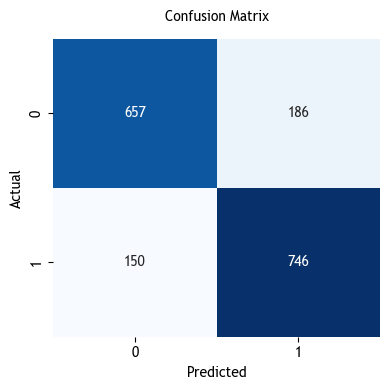

In [597]:
cm = confusion_matrix(y_valid, final_predictions)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

The confusion matrix for the stacking classifier proves that the model maintains a good balance between precision and recall. It correctly identifies a higher number of true positives and true negatives compared to false positives and false negatives.

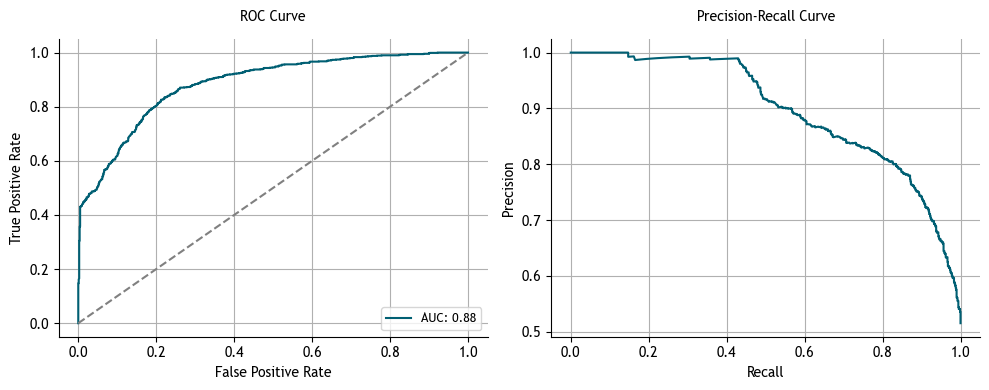

In [602]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
y_proba = stacking_clf.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = roc_auc_score(y_valid, y_proba)
plt.plot(fpr, tpr, color=custom_palette[1], label=f"AUC: {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
prec, recall, _ = precision_recall_curve(y_valid, y_proba)
plt.plot(recall, prec, color=custom_palette[1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)

sns.despine()
plt.tight_layout()
plt.show()

The ROC Curve indicates that the model achieves a high true positive rate while maintaining a relatively low false positive rate. The AUC score of 0.88 further confirms that the model maintains a strong balance between the positive and negative classes.

#### Observations

Moving on, we will analyze the feature importance of the two best performing models. 

In [614]:
categorical_feature_names = (
    preprocessor.named_transformers_["categorical"]
    .named_steps["categorical"]
    .get_feature_names_out(categorical_cols)
)
feature_names = numerical_cols + categorical_feature_names.tolist()

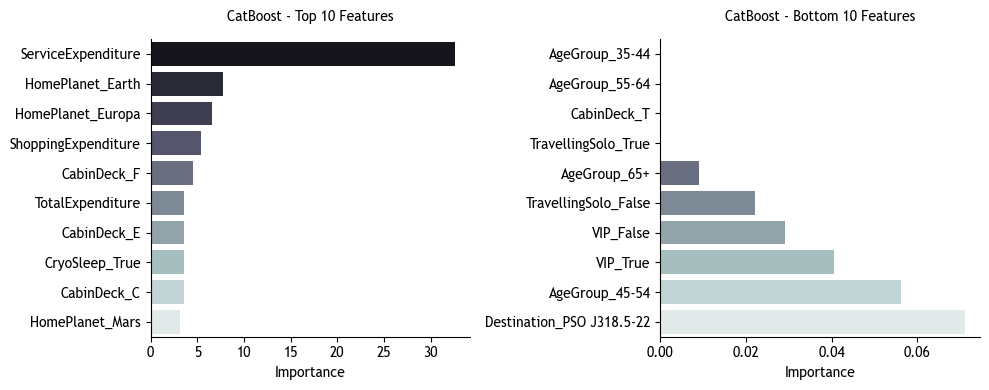

In [616]:
catboost_feature_importances = best_classifiers["CatBoost"].get_feature_importance()

importances_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance": catboost_feature_importances,
    }
).sort_values(by="Importance", ascending=False)

top_15 = importances_df.head(10)
bottom_15 = importances_df.tail(10).iloc[::-1]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.barplot(x="Importance", y="Feature", data=top_15, palette="bone")
plt.title("CatBoost - Top 10 Features")
plt.xlabel("Importance")
plt.ylabel("")

plt.subplot(1, 2, 2)
sns.barplot(x="Importance", y="Feature", data=bottom_15, palette="bone")
plt.title("CatBoost - Bottom 10 Features")
plt.xlabel("Importance")
plt.ylabel("")

sns.despine()
plt.tight_layout()
plt.show()

For CatBoost, the Service Expenditure feature was by far the most important when building the model. Being from Earth or Europa was also significant. Shopping & Total Expenditure and Cabin Decks C, E, and F were also important for the prediction.

On the other hand, Age Groups, Traveling Solo, VIP status, and Cabin Decks T and D appeared to be of minimal importance.

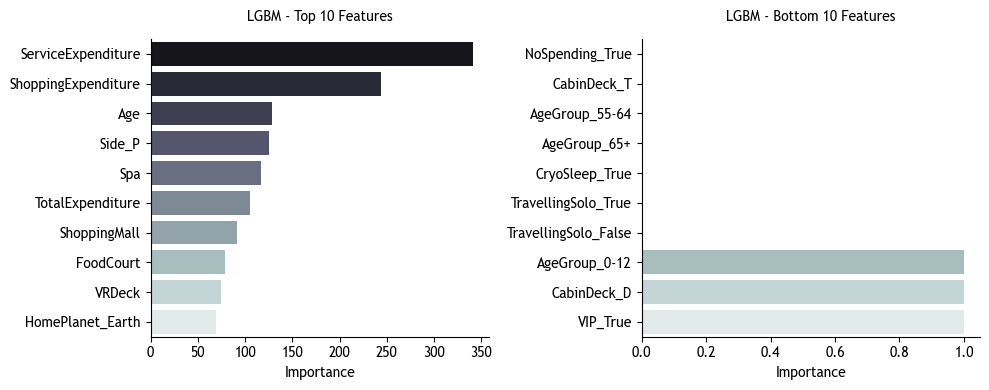

In [618]:
lgbm_model = best_classifiers["LGBM"]

lgbm_feature_importances = lgbm_model.feature_importances_

importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": lgbm_feature_importances}
).sort_values(by="Importance", ascending=False)

top_15 = importances_df.head(10)
bottom_15 = importances_df.tail(10).iloc[::-1]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.barplot(x="Importance", y="Feature", data=top_15, palette="bone")
plt.title("LGBM - Top 10 Features")
plt.xlabel("Importance")
plt.ylabel("")

plt.subplot(1, 2, 2)
sns.barplot(x="Importance", y="Feature", data=bottom_15, palette="bone")
plt.title("LGBM - Bottom 10 Features")
plt.xlabel("Importance")
plt.ylabel("")

sns.despine()
plt.tight_layout()
plt.show()

For LightGBM, the feature importance were more evenly distributed and somewhat different, although Service Expenditure remained the most important. It was closely followed by Shopping Expenses. Among the other expense features, Age and Side-P were also significant.

Once again, Age Groups, No Spending-True, and Traveling Solo were among the least important features.

Both models demonstrate that creating additional features was highly beneficial, even though some of them turned out to be less important.

In [634]:
explainer = shap.Explainer(best_classifiers["CatBoost"])
shap_values = explainer(X_valid)

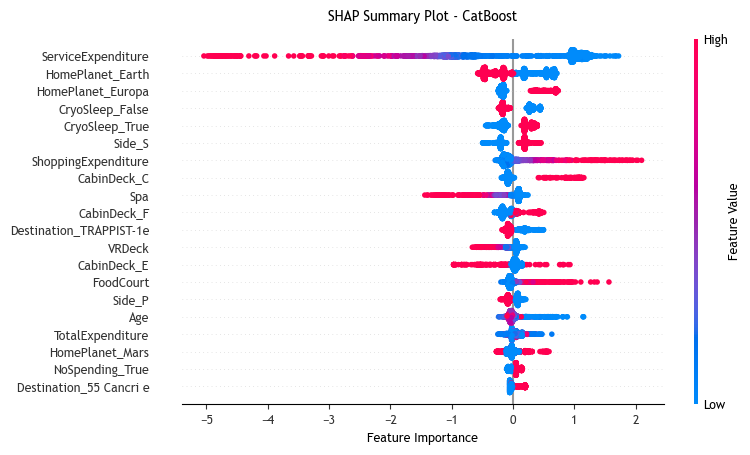

In [636]:
shap.summary_plot(shap_values, X_valid, feature_names=feature_names, show=False)

plt.gcf().set_size_inches(9, 4)

plt.gca().set_xlabel("Feature Importance", fontsize=9)
plt.title("SHAP Summary Plot - CatBoost", fontsize=10)

for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(9)

cbar = plt.gcf().axes[1]
cbar.tick_params(labelsize=9)
cbar.set_ylabel("Feature Value", fontsize=9)

plt.show()

The SHAP summary plot provides an overview of feature importance and the impact of each feature on the model's predictions. 

It reveals that 'Service Expenditure' is the most influential feature, with a wide range of SHAP values. This suggests that lower service spending decreases the likelihood of being transported, while higher spending increases it. Conversely, 'Shopping Expenditure' has a positive association with the likelihood of being transported. 

Binary features, such as 'Home Planet,' show a narrower spread: being from Earth decreases the likelihood of being transported, whereas being from Europa increases it.

In [622]:
explainer = shap.Explainer(best_classifiers["LGBM"])
shap_values = explainer(X_valid)

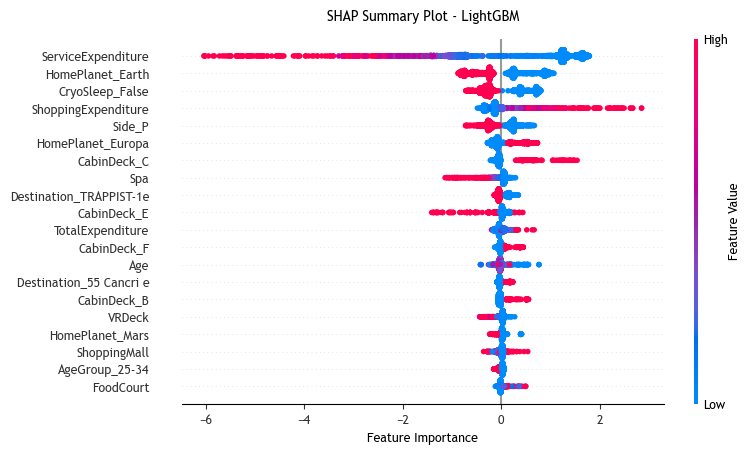

In [624]:
shap.summary_plot(shap_values, X_valid, feature_names=feature_names, show=False)

plt.gcf().set_size_inches(9, 4)

plt.gca().set_xlabel("Feature Importance", fontsize=9)
plt.title("SHAP Summary Plot - LightGBM", fontsize=10)

for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(9)

cbar = plt.gcf().axes[1]
cbar.tick_params(labelsize=9)
cbar.set_ylabel("Feature Value", fontsize=9)

plt.show()

The SHAP summary plot for the LightGBM model is quite similar, displaying an even wider spread of SHAP values for the 'Service Expenditure' feature.

#### Submission

In [649]:
test_predictions = stacking_clf.predict(X_test)

In [651]:
submission = pd.read_csv(
    r"C:\Users\nacev\OneDrive\turing\datasets\sample_submission.csv"
)

submission["Transported"] = test_predictions.astype("bool")

In [653]:
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [655]:
submission.to_csv(r"C:\Users\nacev\OneDrive\turing\submission.csv", index=False)

&nbsp;

---

## Summary and Recommendations

### Summary of the Findings

**Exploratory Data Analysis**

* **Distribution & Key Features:** The target variable "Transported" is nearly balanced. Key features include CryoSleep with a strong effect on transportation, and HomePlanet and Destination showing significant differences in transportation rates.

* **Age & Expenditure Insights:** Younger passengers (0-18) are transported more frequently, while those with higher service expenditures are less likely to be transported. New features were created to further explore these impacts.

* **New Feature Insights:** Features like NoSpending significantly impacted the likelihood of being transported. Group size had a minor effect. Spending patterns indicated that higher ServiceExpenditure decreased and ShoppingExpenditure slightly increased the chance of transportation.

* **Missing Value Analysis and Imputation:** Identified that 24% of rows had missing entries. The dataset was updated to reflect these changes and rules were established for further imputation.

**Statistical Inference**

* **Age Distribution:** A significant difference in age distributions was found between transported and non-transported passengers, indicating that the age of transported passengers (mean = 27.98 years) differs from that of non-transported passengers (mean = 29.99 years).

* **Categorical Variables:** Significant associations were observed between various categorical variables (e.g., CryoSleep, NoSpending) and the likelihood of being transported, with all p-values being less than the adjusted significance level.

**Statistical Modelling**

* **Model Performance:** Among the models tested, LGBM, CatBoost, and XGBoost performed the best, with CatBoost showing the highest validation accuracy. The stacking classifier, combining these top models, slightly outperformed individual models.

* **Evaluation Metrics:** The stacking classifier demonstrated balanced performance across precision, recall, and F1-score. The confusion matrix and ROC curve analysis further confirmed the model's strong predictive capability, with an AUC of 0.88 and well-maintained balance between precision and recall.

* **Feature Importance**: Service Expenditure is the most influential feature, significantly affecting predictions. Other important features include other expenditure features, Home Planet and Cabin Decks. Age Groups and Traveling Solo are less important.

* **SHAP Analysis:** Both models indicate Service Expenditure as a key feature with a broad impact on predictions, with similar patterns observed in the SHAP summary plots for both CatBoost and LGBM.

### Recommendations for Further Analysis

To gain deeper insights and enhance the analysis, the following steps could be considered:

* Hyperparameter Tuning: Experiment with different hyperparameter optimization techniques.
* Feature Engineering: Explore additional feature engineering techniques, to capture more complex relationships in the data.
* Model Comparison: Compare other machine learning models not yet tested, to assess if they provide better performance or insights.
* Anomaly Detection: Investigate if any anomalies in the data could be impacting model performance and how they can be addressed.